## Setup

In [1]:
from sklearn import datasets
import pandas as pd
dataset = datasets.fetch_california_housing(as_frame = True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(1)

dataset.frame_normalized = StandardScaler().fit_transform(dataset.frame)
# We drop Longitude as well since Latitude has enough information
X = dataset.frame_normalized[:,0:len(dataset.frame.columns) - 2]
y = dataset.frame_normalized[:,len(dataset.frame.columns) - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)

n, d = X_train.shape

## Question 1: 
- Apply randomized block coordinate descent to your problem by considering a full batch of your dataset, 
- and compare it with gradient descent. 
- Is the use of coordinate descent beneficial on your problem?

In [9]:
from scipy.linalg import norm
SoftThresh = lambda x, tau: np.sign(x) * np.maximum(np.abs(x)-tau, 0.0)
loss_rcd = lambda A, x, y, lbda: norm(A.dot(x) - y) ** 2 / (2. * n)+ lbda * norm(x,1)
grad_rcd = lambda A, x, y, lbda: A.T.dot(A.dot(x) - y) / n

# Randomized coordinate descent for the LASSO problem
def rcd_lasso(A,y,lbda,ncoord=1,nits=500): 
    """
        Coordinate descent code for LASSO problems of the form
            minimize_x (0.5/n)*||Ax-y||^2 + lbda*||x||_1.
        
        Inputs:
            x0: Initial point
            A: Data matrix
            y: Data vector
            lbda:: Regularization coefficient
            ncoords: Number of coordinates drawn at every iteration
            nits: Maximum number of iterations
            
        Outputs:
            x_output: Last iterate
            objvals: History of function values (Numpy array of length at most nits)
            nnzvals: History of iterate sparsity (Numpy array of length at most nits)
    """
    
    ############
    # Initialization
    objvals = []
    sparsity = []
    
    # Initial iterate
    n,d = A.shape
    x = np.ones(d)
    
    # Lipschitz constants
    Lvals = norm(np.matmul(A.T,A),axis=0)
    objvals.append( loss_rcd(A,x, y, lbda)) # Initial objective value
    sparsity.append(np.count_nonzero(x)/d) # Number of nonzero coefficients

    for k in range(nits):
        g = grad_rcd(A, x, y, lbda) # Gradient for the smooth part of the objective
        # g = g / np.linalg.norm(g)

        jk = np.random.choice(d,ncoord,replace=False) # Uniform draw without replacement
        # Compute the new iterate by changing only one component
        for j in jk:
            stepj = (2/Lvals[j])
            valj = x[j]-stepj*g[j]
            threshold = stepj*lbda
            x[j] = SoftThresh(valj, threshold)

        #Update
        objvals.append(loss_rcd(A, x, y, lbda) )
        sparsity.append(np.count_nonzero(x)/d)
        g = grad_rcd(A, x, y, lbda)
          
    return x, np.array(objvals), np.array(sparsity)

In [10]:
#Different block values

lbda = 2.5 #.5#1/(n**0.5)
nits=10000

th = []
obj = []
sparsity = []

NumBlocks = [i for i in range(1, 9)]

for nb in NumBlocks:
    x1,obj1,nnz1 = rcd_lasso(A=X_train, y=y_train, lbda=lbda, ncoord=nb, nits=nits)
    th.append(x1)
    obj.append(obj1)
    sparsity.append(nnz1)
    print('Block size:',nb)
    print('Func:',np.round(obj1[-1], 4))
    print('Sparsity',nnz1[-1])


Block size: 1
Func: 10.635
Sparsity 0.875
Block size: 2
Func: 3.1295
Sparsity 0.875
Block size: 3
Func: 0.5367
Sparsity 0.125
Block size: 4
Func: 0.4989
Sparsity 0.0
Block size: 5
Func: 0.4989
Sparsity 0.0
Block size: 6
Func: 0.4989
Sparsity 0.0
Block size: 7
Func: 0.4989
Sparsity 0.0
Block size: 8
Func: 0.4989
Sparsity 0.0


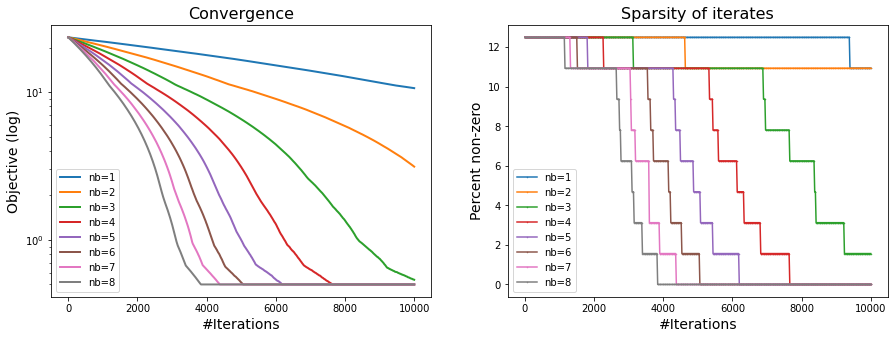

In [11]:
################# Plot the results across all iterations
import matplotlib.pyplot as plt
# Evolution of the loss
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
for i in NumBlocks:
    plt.semilogy(obj[i-1], label=f"nb={i}",lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend();

# # Evolution of the number of zero coordinates
plt.subplot(1,2,2)
itnum = np.arange(nits+1)[::20]
for i in NumBlocks:
    plt.plot(itnum,sparsity[i-1][::20]*100/d,marker='.',label=f'nb={i}', markersize=1)

plt.title("Sparsity of iterates", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Percent non-zero", fontsize=14)
plt.legend();

## Question 2: Stochastic RCD
- Combine randomized block coordinate descent with stochastic gradient (i.e. the method from Part 3). 
- Do you observe a benefit from using coordinates together with stochastic gradient?

In [ ]:
def stochRCD(A, y, nbatch=1, lbda=0, ncoords=1, n_iter=1000, with_replace=False):    
    # Lipschitz constant
    Lvals = norm(np.matmul(A.T,A),axis=0)

    n, d = A.shape
    th = np.ones(d)/d
    
    loss_evol = [loss_rcd(A, th, y, lbda)]
    sparsity = [np.count_nonzero(th)/d]

    k=0
    e = 1
    while (k < n_iter and norm(th,2) < 10**100):
        # SG: batch indices
        ik = np.random.choice(n,nbatch,replace=with_replace)# Batch gradient
        sg = np.zeros(d)
        for j in range(nbatch):
            gradi = (A[i].dot(th) - y[i]) * A[i] #+ lbda*x <-- l2 norm case
            sg = sg + gradi
        sg = (1/nbatch)*sg
        sg = sg / norm(sg)

        #RCD: coordinates
        jk = np.random.choice(d,ncoords,replace=with_replace) 
        for j in jk:
            stepj =  1/Lvals[j] * (1/(k+1))
            valj = th[j] - stepj * sg[j]
            threshold = stepj*lbda
            th[j] = SoftThresh(valj, threshold)
        
        obj = loss_rcd(A, th, y, lbda)
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if k*nbatch - e*n >= 0:
            print("Epoch", e, end='\r')
            e+=1
            loss_evol.append(obj)
            sparsity.append(np.count_nonzero(th)/d)


    loss_evol.append(obj)
    # print('')

    return th, np.array(loss_evol), np.array(sparsity)


In [ ]:
th = []
obj = []
sparsity = []

NumBlocks = np.arange(1, 9, 1)
nb_epochs =20
nbset=int(n/10)

for nb in NumBlocks:
    x1,obj1,spars1 = stochRCD(A=X_train, y=y_train, lbda=0, nbatch=nbset, ncoords=nb, n_iter=int(nb_epochs*n/nbset))
    th.append(x1)
    obj.append(obj1)
    sparsity.append(spars1)
    print(f'Block size: {nb}')
    print('Final func:',np.round(obj1[-1], 7))
    print(f'Sparsity: {spars1[-1]} \n')

Block size: 1
Final func: 0.4673322
Sparsity: 1.0 

Block size: 2
Final func: 0.4673187
Sparsity: 1.0 

Block size: 3
Final func: 0.4673094
Sparsity: 1.0 

Block size: 4
Final func: 0.4672926
Sparsity: 1.0 

Block size: 5
Final func: 0.4673001
Sparsity: 1.0 

Block size: 6
Final func: 0.4672816
Sparsity: 1.0 

Block size: 7
Final func: 0.4672817
Sparsity: 1.0 

Block size: 8
Final func: 0.4672641
Sparsity: 1.0 



In [ ]:
obj = np.array(obj).T
# obj_noreg = obj.copy()
obj.shape

(21, 8)

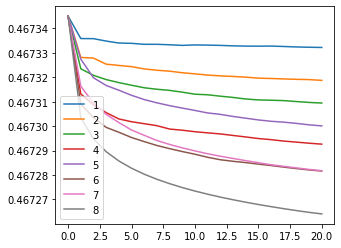

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(obj)
plt.legend(NumBlocks);

### We now compare GD, RCD, SG, BSC
(with no regularisation)

In [54]:
nb_epochs = 20
nbset=int(n/10) #just to speed up runtime

#GD has batch size n and ncoords=d
print("GD")
xGD, objGD, sparsGD = stochRCD(X_train, y_train, nbatch=n, ncoords=d, n_iter=nb_epochs)
# RCD has batch size n and ncoords = 1
print("RCD")
xRCD, objRCD, sparsRCD = stochRCD(X_train, y_train, nbatch=n, ncoords=1, n_iter=nb_epochs)
#SGD has batch size 1 and nblocs=d
print("SG")
xSG, objSG, sparsSG = stochRCD(X_train, y_train, nbatch=nbset, ncoords=d, n_iter=int(nb_epochs*n/nbset))
#BSC
print("BSC")
xBSC, objBSC, sparsBCD = stochRCD(X_train, y_train, nbatch=nbset, ncoords=1, n_iter=int(nb_epochs*n/nbset))



GD
RCDch 20
SGoch 20
BSCch 19


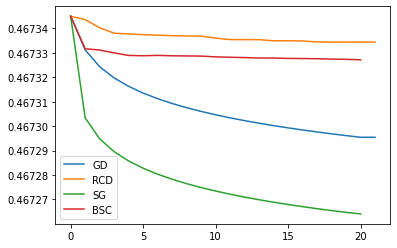

In [55]:
OG = [objGD, objRCD, objSG, objBSC]
# OG = np.array(OG).T #[np.array(i).T for i in OG])
Labels = ['GD', 'RCD', 'SG', 'BSC']
for i in range(len(OG)):
    plt.plot(OG[i])
plt.legend(Labels);
